<a href="https://colab.research.google.com/github/Equipe16-IAA/IAA012-FrameworksIA/blob/main/03_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Sistemas de Recomendação

---

# Exercico 03: Criar um sistema de recomendação de livro

#### 1. Importação das bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---
#### 2. Importação dos dados

In [26]:
#!wget https://marlonprudente.eng.br/files/Base_livros.csv

df = pd.read_csv("Base_livros.csv")
df.head()

<ipython-input-26-d562acd5e23a>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Base_livros.csv")


,ISBN,Titulo,Autor,Ano,Editora,ID_usuario,Notas,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,276725,0,NaN,NaN,NaN,NaN,NaN,NaN
1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,276726,2,NaN,NaN,NaN,NaN,NaN,NaN
2,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,276727,6,NaN,NaN,NaN,NaN,NaN,NaN
3,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,276729,1,NaN,NaN,NaN,NaN,NaN,NaN
4,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,276729,9,NaN,NaN,NaN,NaN,NaN,NaN


---
#### 3. Conversão de userId e movieId para categoria

In [28]:
# userId e movieId não estão no formato certo para usar
# Embeddings > devem ser categóricos

df = df.drop(columns=["Unnamed: 7", "Unnamed: 8", "Unnamed: 9" ,"Unnamed: 10" ,"Unnamed: 11" ,"Unnamed: 12"])
df.head()



,ISBN,Titulo,Autor,Ano,Editora,ID_usuario,Notas
0,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,276725,0
1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,276726,2
2,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,276727,6
3,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,276729,1
4,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,276729,9


In [35]:
# prompt: transformar coluna Notas do df em int

# Convertendo a coluna 'Notas' para tipo numérico (int)
df['Notas'] = pd.to_numeric(df['Notas'], errors='coerce').fillna(0).astype(int)
df['ISBN'] = pd.to_numeric(df['ISBN'], errors='coerce').fillna(0).astype(int)
df['ID_usuario'] = pd.to_numeric(df['ID_usuario'], errors='coerce').fillna(0).astype(int)
df.head()

,ISBN,Titulo,Autor,Ano,Editora,ID_usuario,Notas
0,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,276725,0
1,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,276726,2
2,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,276727,6
3,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,276729,1
4,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,276729,9


In [36]:
# Dimensões
N = len(set(df.ID_usuario))
M = len(set(df.ISBN))

# dimensão do embedding (tentar outros)
K = 10

#### 4. Criar o modelo

In [37]:
# usuário
u = Input(shape=(1,))
u_emb = Embedding(N, K)(u) # saída : num_samples, 1, K
u_emb = Flatten()(u_emb)   # saída : num_samples, K

# filme
m = Input(shape=(1,))
m_emb = Embedding(M, K)(m)  # saída : num_samples, 1, K
m_emb = Flatten()(m_emb)    # saída : num_samples, K

x = Concatenate()([u_emb, m_emb])

x = Dense(1024, activation="relu")(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)

#### 5. Compilação do modelo

In [38]:
model.compile(
    loss="mse",
    optimizer=SGD(learning_rate=0.08, momentum=0.9)
)

#### 6. Separação dos dados e pré-processamento


In [39]:
user_ids, movie_ids, ratings = shuffle(df.ID_usuario, df.ISBN, df.Notas)

Ntrain = int(0.8 * len(ratings)) # separar os dados 80% x 20%

train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]
test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# centralizar as notas
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

#### 7. Treinamento do modelo

In [40]:
epochs = 25
r = model.fit(
    x=[train_user, train_movie],
    y=train_ratings,
    epochs=epochs,
    batch_size=1024,
    verbose=2, # não imprime o progresso
    validation_data=([test_user, test_movie], test_ratings)
)

Epoch 1/25
1/1 - 1s - 1s/step - loss: 12.1875 - val_loss: 14.3386
Epoch 2/25
1/1 - 0s - 401ms/step - loss: 12.1875 - val_loss: 14.3187
Epoch 3/25
1/1 - 0s - 43ms/step - loss: 12.1875 - val_loss: 14.2989
Epoch 4/25
1/1 - 0s - 57ms/step - loss: 12.1875 - val_loss: 14.2855
Epoch 5/25
1/1 - 0s - 57ms/step - loss: 12.1875 - val_loss: 14.2822
Epoch 6/25
1/1 - 0s - 36ms/step - loss: 12.1875 - val_loss: 14.2890
Epoch 7/25
1/1 - 0s - 36ms/step - loss: 12.1875 - val_loss: 14.3027
Epoch 8/25
1/1 - 0s - 35ms/step - loss: 12.1875 - val_loss: 14.3182
Epoch 9/25
1/1 - 0s - 64ms/step - loss: 12.1875 - val_loss: 14.3303
Epoch 10/25
1/1 - 0s - 40ms/step - loss: 12.1875 - val_loss: 14.3355
Epoch 11/25
1/1 - 0s - 40ms/step - loss: 12.1875 - val_loss: 14.3327
Epoch 12/25
1/1 - 0s - 36ms/step - loss: 12.1875 - val_loss: 14.3236
Epoch 13/25
1/1 - 0s - 37ms/step - loss: 12.1875 - val_loss: 14.3119
Epoch 14/25
1/1 - 0s - 61ms/step - loss: 12.1875 - val_loss: 14.3015
Epoch 15/25
1/1 - 0s - 37ms/step - loss: 12.

#### 8. Plotar a função de perda

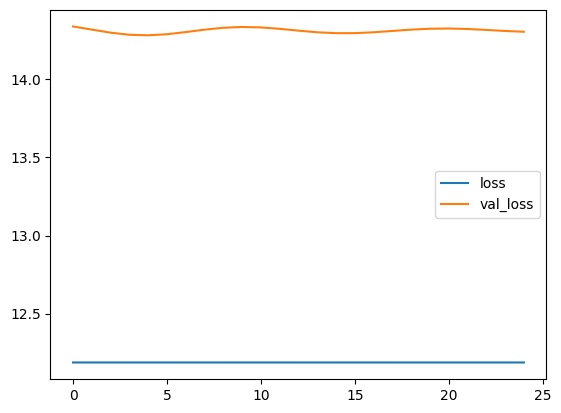

In [41]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

### 9. Recomendações para o usuário 73023

In [48]:
# Gerar o array com o usuário único
# repete a quantidade de filmes
input_usuario = np.repeat(a=276729, repeats=M)
film = np.array(list(set(movie_ids)))

preds = model.predict( [input_usuario, film] )

# descentraliza as predições
rat = preds.flatten() + avg_rating

# índice da maior nota
idx = np.argmax(rat)
book_data = df[df['ISBN'] == film[idx]]
print("Recomendação: Filme - ", film[idx], " / ", rat[idx] , "*")
print("Nome: ", book_data['Titulo'].values[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Recomendação: Filme -  393045218  /  4.2489657 *
Nome:  The Mummies of Urumchi


---

# Fim do código